# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from statistics import mean

def pred_prey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

#We can define common uncertainties and outcomes for each model:
uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                 RealParameter('predation_rate', 0.0005, 0.003),
                 RealParameter('predator_efficiency', 0.001, 0.004),
                 RealParameter('predator_loss_rate', 0.04, 0.08)] 

outcomes = [TimeSeriesOutcome('TIME', function=np.squeeze),
            TimeSeriesOutcome('predators', function=np.squeeze),
            TimeSeriesOutcome('prey', function=np.squeeze)]


#Define the Python model
py_model = Model('Python', function=pred_prey)
py_model.uncertainties = uncertainties
py_model.outcomes = outcomes


nr_experiments = 100

#Using Latin Hypercube sampling
experiments, outcomes = perform_experiments(py_model, nr_experiments, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished


In [3]:
experiments.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001973,0.002961,0.041523,0.020240,0,None,Python
1,0.000674,0.002320,0.068272,0.019957,1,None,Python
2,0.000638,0.002531,0.072431,0.018480,2,None,Python
3,0.001336,0.001204,0.066769,0.031831,3,None,Python
4,0.001570,0.002721,0.061047,0.032256,4,None,Python


In [4]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001973,0.002961,0.041523,0.020240,0,None,Python
1,0.000674,0.002320,0.068272,0.019957,1,None,Python
2,0.000638,0.002531,0.072431,0.018480,2,None,Python
3,0.001336,0.001204,0.066769,0.031831,3,None,Python
4,0.001570,0.002721,0.061047,0.032256,4,None,Python
...,...,...,...,...,...,...,...
95,0.000794,0.003597,0.063112,0.019536,95,None,Python
96,0.001325,0.001343,0.076810,0.029152,96,None,Python
97,0.001508,0.003478,0.052389,0.026203,97,None,Python
98,0.002523,0.003759,0.076642,0.025411,98,None,Python


# Part 1. Regression

Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

In [5]:
# calculate final outcomes
final_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    final_outcomes_prey.append((outcomes['prey'][i][-1]))

In [6]:
# calculate mean values of prey over time 
mean_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean((outcomes['prey'][i])))

In [7]:
# calculate standard deviation over time
std_outcomes_prey = []

for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(((outcomes['prey'][i]))))

### Linear regression final outcomes

In [8]:
# Fit a linear regression model for the final outcomes
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_final = sm.OLS(final_outcomes_prey, x)
res_fin = reg_mod_final.fit()


print(res_fin.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.784
Model:                            OLS   Adj. R-squared (uncentered):              0.775
Method:                 Least Squares   F-statistic:                              87.35
Date:                Tue, 11 May 2021   Prob (F-statistic):                    3.95e-31
Time:                        16:36:37   Log-Likelihood:                         -416.83
No. Observations:                 100   AIC:                                      841.7
Df Residuals:                      96   BIC:                                      852.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [9]:
res_fin.fittedvalues

0      4.660525
1     36.141438
2     37.087923
3     48.919815
4     27.066981
        ...    
95    17.376476
96    55.396859
97    10.075247
98    26.274808
99    14.311257
Length: 100, dtype: float64

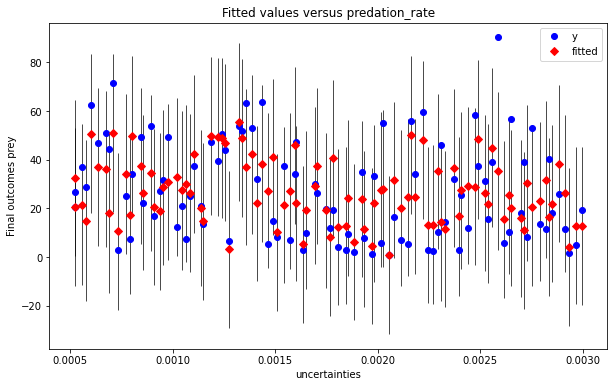

In [10]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_fin, 0, ax=ax)
fig.set_size_inches(10, 6, forward=True)
ax.set_ylabel("Final outcomes prey")
ax.set_xlabel("uncertainties")

plt.show()

In [11]:
predation=[]
for i in range(len(experiments)):
    predation.append(experiments.iloc[i,0])
predator_efficiency=[]
for i in range(len(experiments)):
    predator_efficiency.append(experiments.iloc[i,1])
predator_loss_rate=[]
for i in range(len(experiments)):
    predator_loss_rate.append(experiments.iloc[i,2])
prey_birth=[]
for i in range(len(experiments)):
    prey_birth.append(experiments.iloc[i,3])

In [12]:
ys = res_fin.fittedvalues.values
predation, ys = zip(*sorted(zip(predation, ys)))
predator_efficiency, ys =zip(*sorted(zip(predator_efficiency, ys)))
predator_loss_rate, ys =zip(*sorted(zip(predator_loss_rate, ys)))
prey_birth, ys =zip(*sorted(zip(prey_birth, ys)))

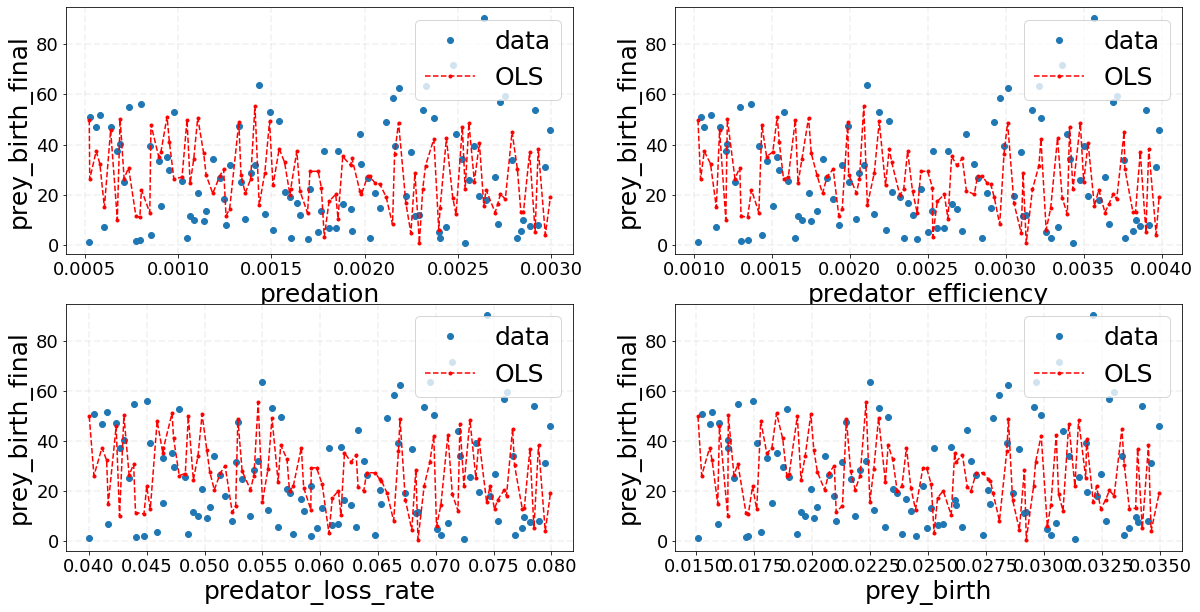

In [13]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].plot(predation,final_outcomes_prey, 'o', label="data")
ax[0,0].tick_params(labelsize=18)
ax[0,0].plot(predation, ys, 'r--.', label="OLS")
ax[0,0].set_xlabel('predation',fontsize=25)
ax[0,0].set_ylabel('prey_birth_final',fontsize=25)
ax[0,0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0,0].legend(fontsize=25,loc="upper right");

ax[0,1].plot(predator_efficiency,final_outcomes_prey, 'o', label="data")
ax[0,1].tick_params(labelsize=18)
ax[0,1].plot(predator_efficiency, ys, 'r--.', label="OLS")
ax[0,1].set_xlabel('predator_efficiency',fontsize=25)
ax[0,1].set_ylabel('prey_birth_final',fontsize=25)
ax[0,1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[0,1].legend(fontsize=25,loc="upper right");

ax[1,0].plot(predator_loss_rate,final_outcomes_prey, 'o', label="data")
ax[1,0].tick_params(labelsize=18)
ax[1,0].plot(predator_loss_rate, ys, 'r--.', label="OLS")
ax[1,0].set_xlabel('predator_loss_rate',fontsize=25)
ax[1,0].set_ylabel('prey_birth_final',fontsize=25)
ax[1,0].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1,0].legend(fontsize=25,loc="upper right");

ax[1,1].plot(prey_birth,final_outcomes_prey, 'o', label="data")
ax[1,1].tick_params(labelsize=18)
ax[1,1].plot(prey_birth, ys, 'r--.', label="OLS")
ax[1,1].set_xlabel('prey_birth',fontsize=25)
ax[1,1].set_ylabel('prey_birth_final',fontsize=25)
ax[1,1].grid(True, lw=1.75, ls='--', alpha=0.15)
ax[1,1].legend(fontsize=25,loc="upper right");

### Linear regression mean values over time

In [14]:
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_mean = sm.OLS(mean_outcomes_prey, x)
res_mean = reg_mod_mean.fit()


print(res_mean.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                              687.5
Date:                Tue, 11 May 2021   Prob (F-statistic):                    1.05e-69
Time:                        16:36:39   Log-Likelihood:                         -309.75
No. Observations:                 100   AIC:                                      627.5
Df Residuals:                      96   BIC:                                      637.9
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

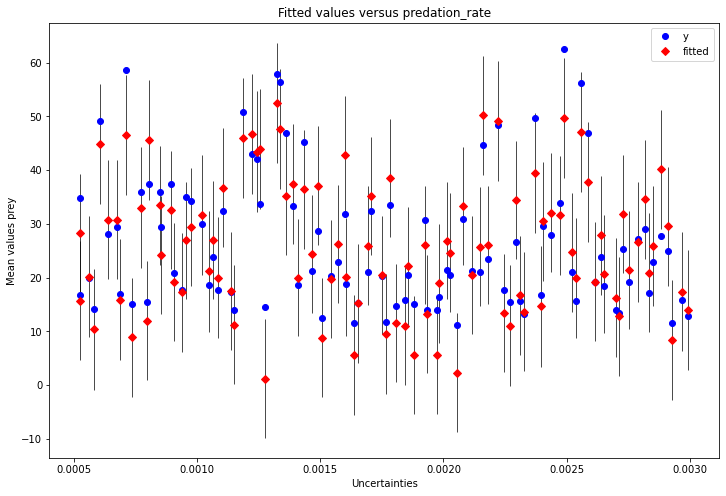

In [15]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_mean, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

### Linear regression model standard deviations over time

In [16]:
x = experiments[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]

reg_mod_std = sm.OLS(std_outcomes_prey, x)
res_std = reg_mod_std.fit()

print(res_std.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.946
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              417.8
Date:                Tue, 11 May 2021   Prob (F-statistic):                    8.78e-60
Time:                        16:36:39   Log-Likelihood:                         -264.79
No. Observations:                 100   AIC:                                      537.6
Df Residuals:                      96   BIC:                                      548.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

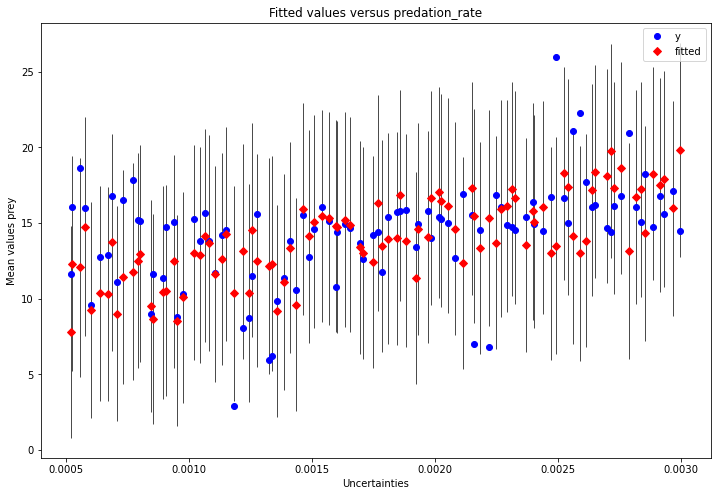

In [17]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res_std, 0, ax=ax)
fig.set_size_inches(12, 8, forward=True)
ax.set_ylabel("Mean values prey")
ax.set_xlabel("Uncertainties")

plt.show()

### Interpretation Regression anlysis

The value of R-squared is the highest for the regression model of the mean values (namely 96,6%), followed by the regression model of the standard deviations (0,946). The R-squared of the final outcomes is significantly lower (0,784). This is in line with our expectations, since the final values are more arbitrary than mean and standard deviations that are computed over the whole model run. Furthermore, it can be seen that for the regression model of the mean values all the predictors are significant (if alpha is 0.05). For the regression model of the outcomes this are only the predator efficiency and the predator_loss_rate. For the regression model of the standard deviation, only the predator_loss_rate is not significant. 

Based on this, it can be concluded that compared with the other indicators, the variance of the mean values of the _prey_ outcome over time, within each experiment, can be predicted the most accurate by the input variables. In this regression model, all the predictors are significant. 

# Part 2. SOBOL sampling

Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

# N=50

In [18]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

sa_results = perform_experiments(py_model, scenarios=50, uncertainty_sampling='sobol')
#now we have 50*(2*4+2)=500 scenarios

[MainProcess/INFO] performing 500 scenarios * 1 policies * 1 model(s) = 500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 350 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 450 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] experiments finished


In [19]:
experiments, outcomes = sa_results
mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)

#### Final values of outcomes

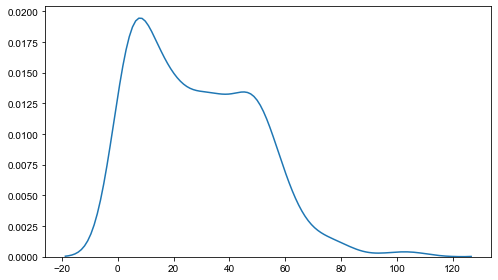

In [20]:
fig, ax = plt.subplots()
sns.kdeplot(outcomes['prey'][:,-1], ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

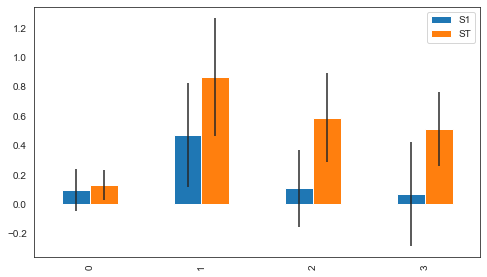

In [21]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Mean values of outcomes

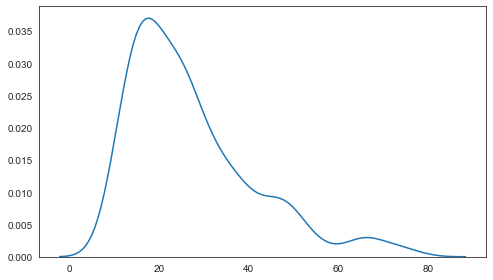

In [22]:
fig, ax = plt.subplots()
sns.kdeplot(mean_outcomes_prey, ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

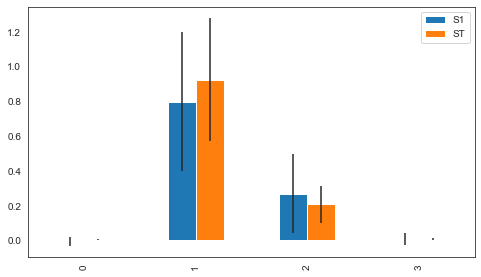

In [23]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Standard deviation of outcomes

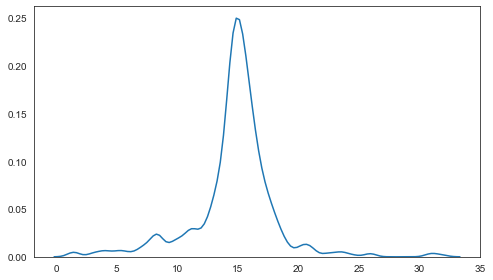

In [24]:
fig, ax = plt.subplots()
sns.kdeplot(std_outcomes_prey, ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

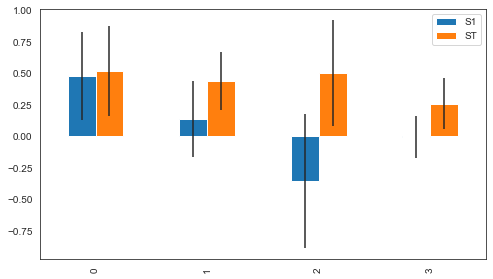

In [25]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [26]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: -0.05663636424058455 with confidence interval 95%: 0.16842725723679047
x1-x3: -0.09661355423709607 with confidence interval 95%: 0.16877243010626794
x1-x4: -0.16452283134429882 with confidence interval 95%: 0.13230745705868158
x2-x3: -0.08742973544859538 with confidence interval 95%: 0.37607429781168306
x2-x4: -0.017606092674970417 with confidence interval 95%: 0.5785930324521046
x3-x4: 0.06080905318883202 with confidence interval 95%: 0.33529650488877544


# N=250

In [27]:
sa_results = perform_experiments(py_model, scenarios=250, uncertainty_sampling='sobol')
#now we have 1000*(2*4+2)=10000 scenarios

[MainProcess/INFO] performing 2500 scenarios * 1 policies * 1 model(s) = 2500 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1750 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2250 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] experiments finished


In [28]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)


#### Final values of outcomes

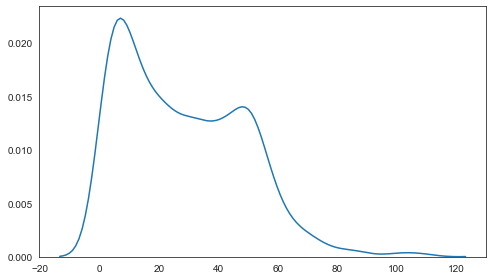

In [29]:
fig, ax = plt.subplots()
sns.kdeplot(outcomes['prey'][:,-1], ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

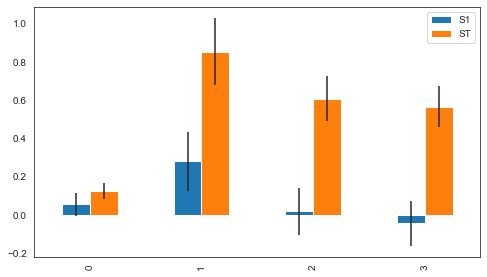

In [30]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Mean values of outcomes

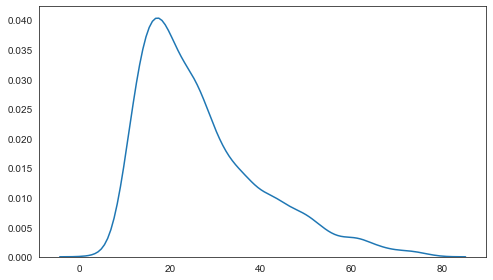

In [31]:
fig, ax = plt.subplots()
sns.kdeplot(mean_outcomes_prey, ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

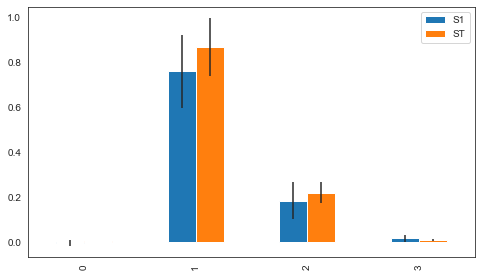

In [32]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered)

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Standard deviation of outcomes

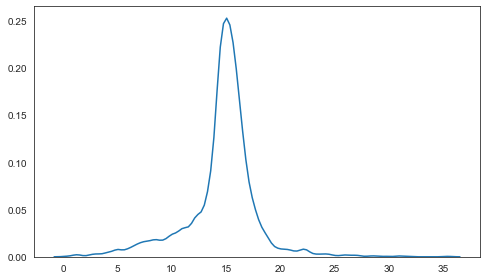

In [33]:
fig, ax = plt.subplots()
sns.kdeplot(std_outcomes_prey, ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

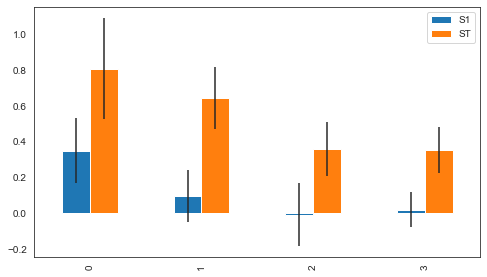

In [34]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [35]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: -0.01674384923636707 with confidence interval 95%: 0.10461435807906089
x1-x3: -0.03496695214254825 with confidence interval 95%: 0.09964846421303232
x1-x4: -0.058457182221766914 with confidence interval 95%: 0.0883346546868443
x2-x3: 0.06726718522442608 with confidence interval 95%: 0.1527177819065581
x2-x4: 0.09590180927757377 with confidence interval 95%: 0.2122855651680849
x3-x4: 0.16003433494045924 with confidence interval 95%: 0.15436110207123524


# N=1000

In [36]:
sa_results = perform_experiments(py_model, scenarios=1000, uncertainty_sampling='sobol')
#now we have 1000*(2*4+2)=10000 scenarios

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [37]:
experiments, outcomes = sa_results

mean_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    mean_outcomes_prey.append(mean(outcomes['prey'][i]))
mean_outcomes_prey=np.array(mean_outcomes_prey)

std_outcomes_prey = []
for i in range(len(outcomes['prey'])):
    std_outcomes_prey.append(np.std(outcomes['prey'][i]))
std_outcomes_prey=np.array(std_outcomes_prey)

problem = get_SALib_problem(py_model.uncertainties)
Si_final = sobol.analyze(problem, outcomes['prey'][:,-1],
                   calc_second_order=True, print_to_console=False)
Si_mean = sobol.analyze(problem, mean_outcomes_prey,
                   calc_second_order=True, print_to_console=False)
Si_std = sobol.analyze(problem, std_outcomes_prey,
                   calc_second_order=True, print_to_console=False)

#### Final values of outcomes

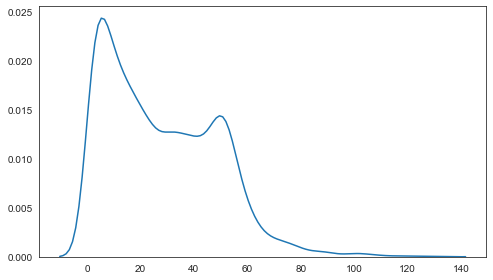

In [38]:
fig, ax = plt.subplots()
sns.kdeplot(outcomes['prey'][:,-1], ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

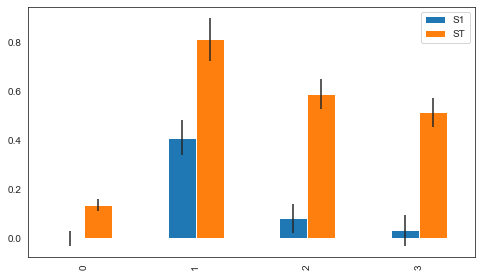

In [39]:
scores_filtered = {k:Si_final[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_finalplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_finalplot[['S1','ST']]
err = Si_finalplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Mean values of outcomes

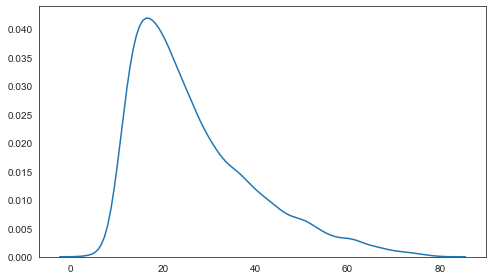

In [40]:
fig, ax = plt.subplots()
sns.kdeplot(mean_outcomes_prey, ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

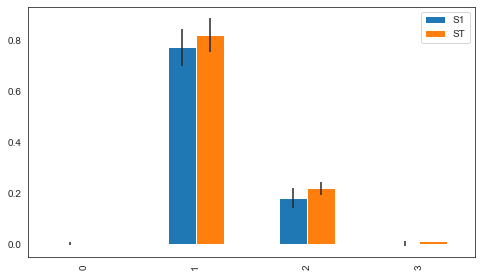

In [41]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

#### Standard deviation of outcomes

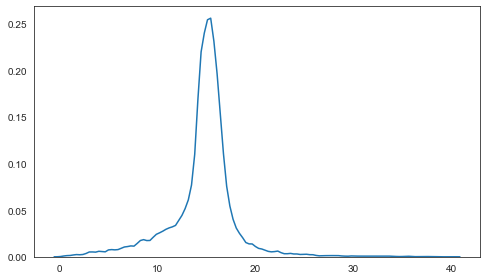

In [42]:
fig, ax = plt.subplots()
sns.kdeplot(std_outcomes_prey, ax = ax)
sns.set_style('white')
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

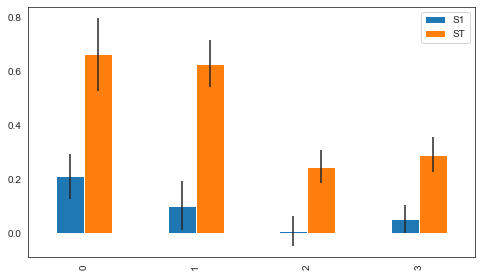

In [43]:
scores_filtered = {k:Si_std[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_stdplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_stdplot[['S1','ST']]
err = Si_stdplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()

In [44]:
print("x1-x2:", Si_final['S2'][0,1], "with confidence interval 95%:", Si_final['S2_conf'][0,1])
print("x1-x3:", Si_final['S2'][0,2], "with confidence interval 95%:", Si_final['S2_conf'][0,2])
print("x1-x4:", Si_final['S2'][0,3], "with confidence interval 95%:", Si_final['S2_conf'][0,3])
print("x2-x3:", Si_final['S2'][1,2], "with confidence interval 95%:", Si_final['S2_conf'][1,2])
print("x2-x4:", Si_final['S2'][1,3], "with confidence interval 95%:", Si_final['S2_conf'][1,3])
print("x3-x4:", Si_final['S2'][2,3], "with confidence interval 95%:", Si_final['S2_conf'][2,3])

x1-x2: 0.009710041117877488 with confidence interval 95%: 0.044501602231716585
x1-x3: 0.0015820596295359063 with confidence interval 95%: 0.03954833943602846
x1-x4: 0.009355983936250544 with confidence interval 95%: 0.04080704543251911
x2-x3: -0.06300859493192545 with confidence interval 95%: 0.09983334797948398
x2-x4: -0.04956582966684217 with confidence interval 95%: 0.08816789548812784
x3-x4: 0.06476259943354126 with confidence interval 95%: 0.08151243596780988


### Interpretation SOBOL analysis

Before executing the SOBOL analysis it is paramount to check whether the outcomes of the experiments are unimodely ditributed. Therefor, a kernel density plot is made. It can be seen that as the sample size gets bigger, the graphs do have a closer approach to the normal distribution. The final outcomes of the prey variable are still not gaussian with a sample size of 1000, this could be the reason why the SOBOL plot still generates slightly negative results for one of the predictors. 

Another remarkable fact is that for the sample size of 1000 (which is the most reliable), the interaction effects are the highest for the standard deviation of the outcomes. This can be seen because the values of the total order sensitivity index (STi) for the different features are much higher than the first order sensitivity index (Si). The first-order sensitivity index Si accounts for the contribution of the factor Xi to the output variation.The total-order sensitivity index STi accounts for all the contributions to the output variation due to factor Xi (i.e. first-order index plus all its interactions).
For the mean values, this is the other way around, the direct effects are almost as large as the total effects on the output variation. 

For the mean values of the outcome and the final outcomes, the predator_efficiecy and predator loss input variables have the largest contribution to the variance in the outcome variables. For the standard deviation of the outcomes, the predation rate and the predator efficiency have the largest contributions. This is more or less the same as for the regression analysis. 

# Part 3. Extra-Trees feature selection

Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [45]:
keys = ['predators', 'prey']
filtered = dict(zip(keys, [outcomes[k] for k in keys]))

In [46]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = filtered

fs = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=100, max_features=0.6,mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


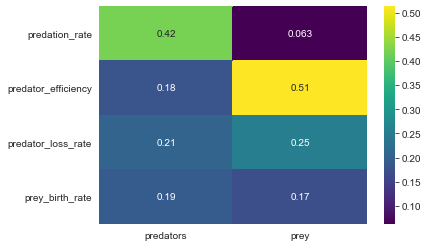

In [47]:
import seaborn as sns
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

In [48]:
fs

,predators,prey
predation_rate,0.420768,0.062978
predator_efficiency,0.180369,0.512951
predator_loss_rate,0.206128,0.253526
prey_birth_rate,0.192736,0.170545


In [49]:
Si_final

{'S1': array([-0.00254622,  0.40766452,  0.07980894,  0.03042556]),
 'S1_conf': array([0.02917623, 0.07177641, 0.05877559, 0.06309482]),
 'ST': array([0.13278521, 0.80937657, 0.58597417, 0.51156524]),
 'ST_conf': array([0.02446492, 0.08692857, 0.06225623, 0.05822745]),
 'S2': array([[        nan,  0.00971004,  0.00158206,  0.00935598],
        [        nan,         nan, -0.06300859, -0.04956583],
        [        nan,         nan,         nan,  0.0647626 ],
        [        nan,         nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.0445016 , 0.03954834, 0.04080705],
        [       nan,        nan, 0.09983335, 0.0881679 ],
        [       nan,        nan,        nan, 0.08151244],
        [       nan,        nan,        nan,        nan]])}

In [50]:
# Check stability of number of trees

x = experiments
y = filtered

fs_1 = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=120, max_features=0.6, mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


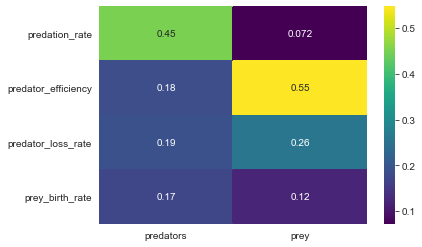

In [52]:
sns.heatmap(fs_1, cmap='viridis', annot=True)
plt.show()

In [53]:
# Check stability of max_features

from ema_workbench.analysis import feature_scoring

x = experiments
y = filtered

fs_2 = feature_scoring.get_feature_scores_all(x,y, alg='extra trees', nr_trees=100, max_features=1.3,mode=RuleInductionType.REGRESSION)

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


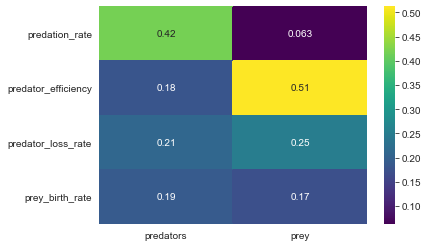

In [56]:
sns.heatmap(fs_2, cmap='viridis', annot=True)
plt.show()

The predator variable is primarly influenced by the predation rate. The predation rate has the largest influence on the prey variable. As can be concluded from the analysis above, the estimated importances are not stable yet relative to the input parameters. The prediction error of the importances change whenever the maximum number of features or the number of trees in the forest is increased. For the number of trees, this is a typical trade-off between accurancy and time, as an increasing number of trees will be computationaly more heavy but also more accurate, because a larger part of the input space is taken into consideration. The parameter max_feature tells something about the correlation between the trees, the lower the values the more randomness in the trees. The value that is often used for the max_features is p/3, which is in our case equal to 1.3. 

##### Comparison between SOBOL and extra trees 

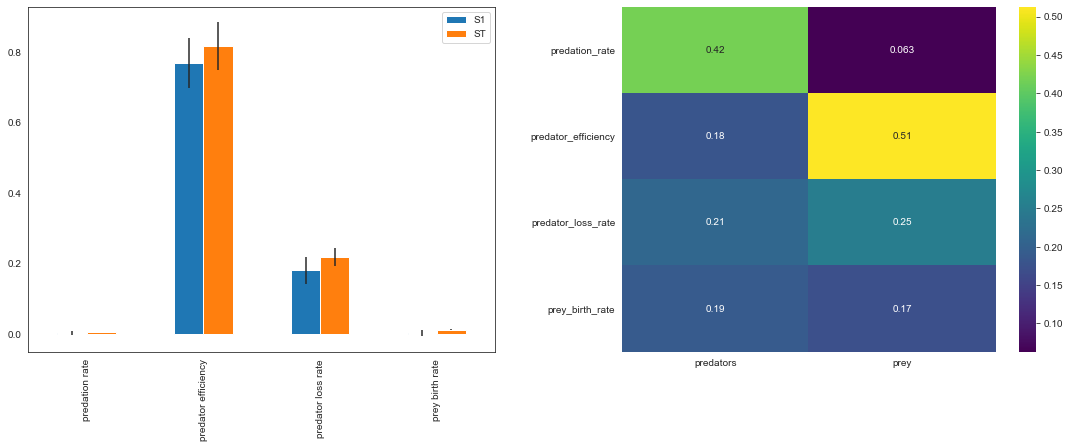

In [93]:
scores_filtered = {k:Si_mean[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_meanplot = pd.DataFrame(scores_filtered, index=['predation rate', 'predator efficiency', 'predator loss rate', 'prey birth rate'])

sns.set_style('white')
fig, ax = plt.subplots(1, 2)

indices = Si_meanplot[['S1','ST']]
err = Si_meanplot[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax[0])
sns.heatmap(fs_2, cmap='viridis', annot=True, ax = ax[1])
fig.set_size_inches(16,7)
fig.subplots_adjust(bottom=0.3)
fig.tight_layout(pad=3.5)
plt.show()

In the SOBOL analysis, only the prey outcome is included. The parameter ranking is the same for both the SOBOL and the Extra Trees algorithm. For both the SOBOL analysis and the Extra Trees the variable 'predator_efficiency' has the largest impact on the variation of the prey outcome, followed with the predator loss rate, the prey birth rate and the predation rate. 